<a href="https://colab.research.google.com/github/Lucas-Rattighieri/tr-fqa/blob/main/TR_FALQON_MaxCut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Importação das Bibliotecas

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpy.linalg as npl
import scipy.linalg as la
import torch
import networkx as nx

In [ ]:
#@title Configuração Pytorch

dtype = torch.complex128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title FQA e FALQON

# Computes the action of exp(-i * theta * Hx) on psi, where Hx = \sum_i x_i
def expX(psi, theta, L, index):
    ctheta = torch.cos(theta)
    istheta = 1j * torch.sin(theta)

    for a in range(L):
        b = 1 << a
        new_index = index ^ b

        psi.mul_(ctheta).sub_(psi[new_index].mul(istheta))

    return psi

# Computes the action of Hx operator on psi
def hX(psi, L, index):
    Hxpsi = torch.zeros_like(psi)

    for a in range(L):
        b = 1 << a
        new_index = index ^ b
        Hxpsi.add_(psi[new_index])

    return Hxpsi


def falqonHx(L, Hp, Psi, dt, layers, beta0, layers_psis=None, return_data=False, show_data=0):
    index = torch.arange(2**L, dtype=torch.int64, device=Psi.device)

    # Precompute the evolution under Hp
    Up = torch.exp(-1j * dt * Hp)

    # Initialize beta parameter
    beta = torch.tensor(beta0, device=device, dtype=torch.complex128)

    if return_data:
        recorded_energies = []
        recorded_betas = []
        psis = []
    if layers_psis is None:
        layers_psis = [layers]

    for i in range(1, layers + 1):
        # Apply the evolution operator of Hp
        UpPsi = Up * Psi

        # Apply the evolution operator of X
        Psi = expX(UpPsi, beta * dt, L, index)

        if layers_psis is not None:
            if i in layers_psis:
                psis.append(Psi.clone())

        # Compute Hp @ Psi
        HpPsi = Hp * Psi

        # Compute Hx @ Hp @ Psi
        HxHpPsi = hX(HpPsi, L, index)

        # Compute <Psi| HxHp |Psi>
        PsiHxHpPsi = torch.vdot(Psi, HxHpPsi)

        # Update beta = -i(<Psi| HxHp |Psi> - (<Psi| HxHp |Psi>)*)
        beta = -1j * (PsiHxHpPsi - torch.conj(PsiHxHpPsi))

        if return_data:
            # Record the energy <Psi|Hp|Psi>
            energy = torch.vdot(Psi, HpPsi)

            recorded_energies.append(float(energy.real))
            recorded_betas.append(float(beta.real))

            if show_data and i % show_data == 0:
                print(f"Layer {i}, E = {energy.real}")

    return (psis, recorded_energies, recorded_betas) if return_data else psis


In [ ]:
#@title TR-Falqon


def TR_falqonHx(L, Hp, Psi, dt, layers, a, tf, frt, dfrt, beta0, layers_psis=None, return_data=False, show_data=0):
    index = torch.arange(2**L, dtype=torch.int64, device=Psi.device)

    # Initialize beta parameter
    beta = torch.tensor(beta0, device=device, dtype=torch.complex128)

    if return_data:
        recorded_energies = []
        recorded_betas = []
        psis = []
    if layers_psis is None:
        layers_psis = [layers]

    for i in range(1, layers + 1):
        # Compute time-dependent scaling factor
        df_tau = dfrt(dt * (i + 1), tf, a)

        # Apply evolution under Hp
        Up = torch.exp(-1j * Hp * df_tau * dt)
        UpPsi = Up * Psi

        # Apply evolution under Hx
        Psi = expX(UpPsi, df_tau * beta * dt, L, index)

        if layers_psis is not None:
            if i in layers_psis:
                psis.append(Psi.clone())

        HpPsi = Hp * Psi

        # Apply Hx operator to HpPsi
        HxHpPsi = hX(HpPsi, L, index)

        # Compute <Psi| HxHp |Psi>
        PsiHxHpPsi = torch.vdot(Psi, HxHpPsi)

        # Update beta with time-rescaling factor
        beta = -1j * (PsiHxHpPsi - torch.conj(PsiHxHpPsi)) / dfrt(dt * (i + 2), tf, a)

        if return_data:
            # Record the energy <Psi|Hp|Psi>
            energy = torch.vdot(Psi, HpPsi)

            recorded_energies.append(float(energy.real))
            recorded_betas.append(float(beta.real))

            if show_data and i % show_data == 0:
                print(f"Layer {i}, E = {energy.real}")

    return (psis, recorded_energies, recorded_betas) if return_data else psis


In [ ]:
#@title Time-Rescaling Functions


def frt1(tau, tf=10, a=1):
    # Time-rescaling function frt1.
    return a * tau - (tf / (2 * np.pi * a)) * (a - 1) * np.sin((2 * np.pi * a / tf) * tau)

def dfrt1(tau, tf=10, a=1):
    # Derivative of the time-rescaling function frt1.
    return a - (a - 1) * np.cos((2 * np.pi * a / tf) * tau)

def frt2(tau, tf=10, a=1):
    # Time-rescaling function frt2.
    return (2 * (a**2 - a**3) / tf**2) * tau**3 + (3 * (a**2 - a) / tf) * tau**2 + tau

def dfrt2(tau, tf=10, a=1):
    # Derivative of the time-rescaling function frt2.
    return (6 * (a**2 - a**3) / tf**2) * tau**2 + (6 * (a**2 - a) / tf) * tau + 1


In [ ]:
#@title Tensor Product

def pauli_chain(L, op, pos, coef=1):
    # Constructs the tensor product for a Pauli operator with diagonal representation acting on specific sites.

    if coef == 0:
        return torch.zeros(2**L, dtype=dtype, device=device)

    pos = sorted(pos)
    j = 0
    product = torch.ones([1], dtype=dtype, device=device) * coef

    for i in pos:
        if i - j == 0:
            product = torch.kron(product, op)
        else:
            identity = torch.ones(2**(i - j), dtype=dtype, device=device)
            product = torch.kron(product, identity)
            product = torch.kron(product, op)
        j = i + 1
    else:
        identity = torch.ones(2**(L - j), dtype=dtype, device=device)
        product = torch.kron(product, identity)

    return product

def tensor_product(*matrices):
    # Computes the tensor product of multiple matrices.
    product = matrices[0].clone()
    for matrix in matrices[1:]:
        product = torch.kron(product, matrix)
    return product



In [ ]:
#@title MaxCut Hamiltonian with diagonal Pauli operators.

sigma_z = torch.tensor([1, -1], dtype=torch.complex128, device=device)
idn = torch.ones(2, dtype=torch.complex128, device=device)

def Hmaxcut(L, w):
    # Builds the MaxCut Hamiltonian for a graph with L nodes and weighted adjacency matrix w.
    H = torch.zeros(2**L, dtype=torch.complex128, device=device)

    for i in range(L):
        for j in range(L):
            if w[i, j] != 0:
                ZiZj = [i, j]
                term = pauli_chain(L, sigma_z, ZiZj, coef=w[i, j] / 2)
                H = H + term
    return H


In [ ]:
L = 24
grau = 3


G = nx.random_regular_graph(grau, L)
# G = nx.complete_graph(L)

for (u, v) in G.edges():
    G[u][v]['weight'] = np.random.randint(1, 11)

In [ ]:
w = nx.adjacency_matrix(G).toarray()

np.save(f"w_{L}.npy", w)

In [ ]:
probs = [[], []]
trprobs1 = [[], []]
trprobs2 = [[], []]
emin = [0,0]
estado = [0,0]
dts = [0.04, 0.03]
layers = [400, 600]
beta0 = 0
layers_psis = [[50, 100, 200, 400], [200, 400, 500, 600]]

Ls = [16, 24]

In [ ]:
grafico = 0

L = Ls[grafico]

w = np.load(f"w_{L}.npy")

In [ ]:
Hp = Hmaxcut(L, w)

Psi = torch.ones(2**L, dtype=torch.complex128, device=device)
Psi /= np.sqrt(2**L)


In [ ]:
emin[grafico] = float(torch.min(Hp.real))
estado[grafico] = int(torch.argmin(Hp.real))


print(emin[grafico], estado[grafico])

-5.449999999999999 5880


In [ ]:
psis, energias, betas = falqonHx(L, Hp, Psi, dts[grafico], layers[grafico], beta0, layers_psis[grafico], retornar_dados=True, mostrar_dados=50)
probs[grafico] = []
for psi in psis:
    prob_s = float(torch.abs(psi[estado[grafico]]) ** 2) + float(torch.abs(psi[~estado[grafico] & ((1<<L)-1)]) ** 2)
    probs[grafico].append(prob_s)



Layer 50, E = -2.4041649646979684
Layer 100, E = -3.0604644198659225
Layer 150, E = -3.5348869510434673
Layer 200, E = -3.920769425209266
Layer 250, E = -4.236250475579551
Layer 300, E = -4.488986373883523
Layer 350, E = -4.681427820822387
Layer 400, E = -4.8298250640187295


In [ ]:
a = 2
tf = dts[grafico] * layers[grafico]

trpsis1, trenergias1, trbetas1 = TR_falqonHx(L, Hp, Psi, dts[grafico], layers[grafico], a, tf, frt1, dfrt1, beta0, layers_psis[grafico], retornar_dados=True, mostrar_dados=50)
trprobs1[grafico] = []
for psi in trpsis1:
    prob_s = float(torch.abs(psi[estado[grafico]]) ** 2) + float(torch.abs(psi[~estado[grafico] & ((1<<L)-1)]) ** 2)
    trprobs1[grafico].append(prob_s)


Layer 50, E = -3.0133149089670077
Layer 100, E = -4.61943940315027
Layer 150, E = -4.926231502508472
Layer 200, E = -4.9656191661370155
Layer 250, E = -5.003685723786491
Layer 300, E = -5.043383330316419
Layer 350, E = -5.051988144795182
Layer 400, E = -5.052831451974045


In [ ]:
trpsis2, trenergias2, trbetas2 = TR_falqonHx(L, Hp, Psi, dts[grafico], layers[grafico], a, tf, frt2, dfrt2, beta0, layers_psis[grafico], retornar_dados=True, mostrar_dados=50)
trprobs2[grafico] = []
for psi in trpsis2:
    prob_s = float(torch.abs(psi[estado[grafico]]) ** 2) + float(torch.abs(psi[~estado[grafico] & ((1<<L)-1)]) ** 2)
    trprobs2[grafico].append(prob_s)


Layer 50, E = -3.3423138643985606
Layer 100, E = -4.578556462684328
Layer 150, E = -4.905681035716056
Layer 200, E = -4.979335105635703
Layer 250, E = -4.987163160436794
Layer 300, E = -5.021582197357601
Layer 350, E = -5.046058641920714
Layer 400, E = -5.055650297526276


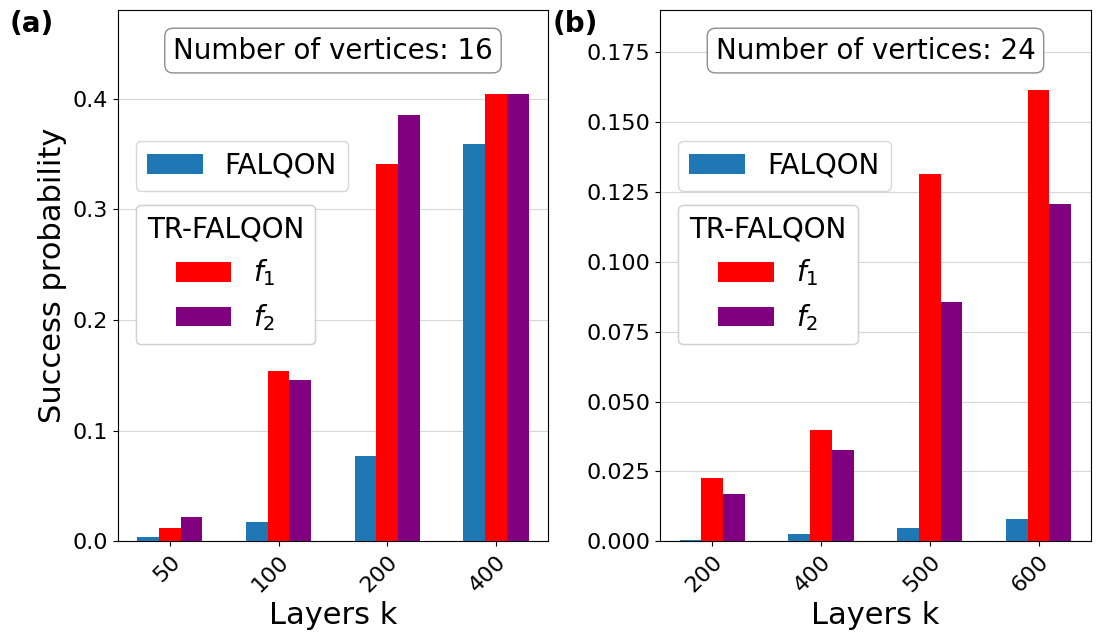

In [ ]:
#@title Gráfico


fig, axs = plt.subplots(1, 2, figsize=(11, 6.5))

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)


x = np.arange(len(layers_psis[0]))
width = 0.2



line1 = axs[0].bar(x - width, probs[0], width=width, label='FALQON', color='#1f77b4', zorder = 3)
line2 = axs[0].bar(x, trprobs1[0], width=width, label='TR-FALQON', color='red', zorder = 3)
line3 = axs[0].bar(x + width, trprobs2[0], width=width, label='TR-FALQON+FALQON', color='purple', zorder = 3)
handles = [line1, line2, line3]
labels = ["FALQON", "$f_1$",  "$f_2$"]

axs[0].set_xticks(x)

legend1 = axs[0].legend(handles[:1], labels[:1], fontsize=20, loc='upper left', bbox_to_anchor=(0.01, 0.78), frameon=True, framealpha=0.8)
axs[0].add_artist(legend1)

legend2 = axs[0].legend(handles[1:], labels[1:], title='TR-FALQON', fontsize=20, title_fontsize = 20, loc='upper left', bbox_to_anchor=(0.01, 0.66), frameon=True, framealpha=0.8)
axs[0].add_artist(legend2)


axs[0].grid(alpha=0.5, axis='y', zorder=0)



xtick_labels = [str(idx) for idx in layers_psis[0]]
axs[0].set_xticklabels(xtick_labels, rotation=45, ha='right', rotation_mode='anchor')



axs[0].set_xlabel(r"Layers k", fontsize=22)
axs[0].set_ylabel(r"Success probability", fontsize=22)
axs[0].set_ylim(0, 0.48)


axs[0].tick_params(axis='both', which='major', labelsize=16)

axs[0].text(0.5, 0.95, 'Number of vertices: 16', transform=axs[0].transAxes,
            fontsize=20, bbox=bbox_props, ha='center', va='top')


x = np.arange(len(layers_psis[1]))
width = 0.2



line1 = axs[1].bar(x - width, probs[1], width=width, color='#1f77b4', zorder = 3)
line2 = axs[1].bar(x, trprobs1[1], width=width, color='red', zorder = 3)
line3 = axs[1].bar(x + width, trprobs2[1], width=width, color='purple', zorder = 3)
handles = [line1, line2, line3]
labels = ["FALQON", "$f_1$",  "$f_2$"]

axs[1].set_xticks(x)

legend1 = axs[1].legend(handles[:1], labels[:1], fontsize=20, loc='upper left', bbox_to_anchor=(0.01, 0.78), frameon=True, framealpha=0.8)
axs[1].add_artist(legend1)

legend2 = axs[1].legend(handles[1:], labels[1:], title='TR-FALQON', fontsize=20, title_fontsize = 20, loc='upper left', bbox_to_anchor=(0.01, 0.66), frameon=True, framealpha=0.8)
axs[1].add_artist(legend2)
axs[1].grid(alpha=0.5, axis='y', zorder=0)



xtick_labels = [str(idx) for idx in layers_psis[1]]
axs[1].set_xticklabels(xtick_labels, rotation=45, ha='right', rotation_mode='anchor')



axs[1].set_xlabel(r"Layers k", fontsize=22)
axs[1].set_ylim(0, 0.19)


axs[0].text(-0.25, 1, '(a)', transform=axs[0].transAxes, fontsize=20, fontweight='bold', va='top')
axs[1].text(-0.25, 1, '(b)', transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='top')


axs[1].tick_params(axis='both', which='major', labelsize=16)

axs[1].text(0.5, 0.95, 'Number of vertices: 24', transform=axs[1].transAxes,
            fontsize=20, bbox=bbox_props, ha='center', va='top')


plt.tight_layout()
plt.savefig("grafico1_tr.pdf")
plt.show()